In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
#import tensorflow.compat.v1 as tf
#tf.disable_v2_behavior()
import tensorflow as tf
print(f'tf={tf.__version__}')
from tensorflow import keras
print(f'keras={keras.__version__}')
def solve_cudnn_error():
    gpus = tf.config.experimental.list_physical_devices('GPU')
    if gpus:
        try:
            # Currently, memory growth needs to be the same across GPUs
            for gpu in gpus:
                tf.config.experimental.set_memory_growth(gpu, True)
            logical_gpus = tf.config.experimental.list_logical_devices('GPU')
            print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
        except RuntimeError as e:
            # Memory growth must be set before GPUs have been initialized
            print(e)
solve_cudnn_error()

tf=2.3.0
keras=2.4.0
1 Physical GPUs, 1 Logical GPUs


In [3]:
import os  # 處理字串路徑
import glob  # 查詢檔案
import numpy as np
import tensorflow.keras as keras
from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import *
from sklearn.metrics import confusion_matrix
from tensorflow.keras.models import load_model
import itertools
import matplotlib.pyplot as plt
from PIL import Image

In [4]:
from tensorflow.keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [5]:
import shutil
import pandas as pd

In [6]:
data = pd.read_csv('DATA/train.csv') 
trainData = data['image_id']
train_labels = data['label']
if not os.path.isdir('DATA/train'):
    os.makedirs('DATA/train')
if not os.path.isdir('DATA/train/A'):
    os.makedirs('DATA/train/A')
if not os.path.isdir('DATA/train/B'):
    os.makedirs('DATA/train/B')
if not os.path.isdir('DATA/train/C'):
    os.makedirs('DATA/train/C')
for i in range(len(data)):
    shutil.copy('DATA/Train_Image/'+trainData[i], 'DATA/train/'+train_labels[i])
# print(trainData)
# print(train_labels)

In [7]:
data = pd.read_csv('DATA/Test.csv') 
testData = data['image_id']
test_labels = data['label']
if not os.path.isdir('DATA/test'):
    os.makedirs('DATA/test')
if not os.path.isdir('DATA/test/A'):
    os.makedirs('DATA/test/A')
if not os.path.isdir('DATA/test/B'):
    os.makedirs('DATA/test/B')
if not os.path.isdir('DATA/test/C'):
    os.makedirs('DATA/test/C')
for i in range(len(data)):
    shutil.copy('DATA/Test_Image/'+testData[i], 'DATA/test/'+test_labels[i])

In [8]:
train_path = 'DATA/train'
valid_path = 'DATA/test'
test_path = 'DATA/test'

In [18]:
train_datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [19]:
train_batches = train_datagen.flow_from_directory(train_path, target_size=(128,128), 
                                                         classes=['A',
                                                                  'B',
                                                                  'C'], batch_size=4)
valid_batches = ImageDataGenerator().flow_from_directory(valid_path, target_size=(128,128), 
                                                         classes=['A',
                                                                  'B',
                                                                  'C'], batch_size=4)

Found 6130 images belonging to 3 classes.
Found 250 images belonging to 3 classes.


In [20]:
model = Sequential(name='VGG16')
model.add(Convolution2D(64,(3, 3), activation='relu',name='block1_conv1',padding='same',input_shape=(128, 128, 3)))
# model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(64,(3, 3), activation='relu',name='block1_conv2',padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(128,(3, 3), activation='relu',name='block2_conv1',padding='same'))
# model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(128,(3, 3), activation='relu',name='block2_conv2',padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(256,(3, 3), activation='relu',name='block3_conv1',padding='same'))
# model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(256,(3, 3), activation='relu',name='block3_conv2',padding='same'))
# model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(256,(3, 3), activation='relu',name='block3_conv3',padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512,(3, 3), activation='relu',name='block4_conv1',padding='same'))
# model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512,(3, 3), activation='relu',name='block4_conv2',padding='same'))
# model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512,(3, 3), activation='relu',name='block4_conv3',padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# # model.add(ZeroPadding2D((1,1)))
# model.add(Convolution2D(512,(3, 3), activation='relu',name='block5_conv1',padding='same'))
# # model.add(ZeroPadding2D((1,1)))
# model.add(Convolution2D(512,(3, 3), activation='relu',name='block5_conv2',padding='same'))
# # model.add(ZeroPadding2D((1,1)))
# model.add(Convolution2D(512,(3, 3), activation='relu',name='block5_conv3',padding='same'))
# model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten(name='flatten'))
model.add(Dense(4096, activation='relu',name='fc1'))
model.add(Dropout(0.5))
model.add(Dense(4096, activation='relu',name='fc2'))
model.add(Dropout(0.5))
model.add(Dense(3, activation='softmax',name='predictions'))
model.summary()

Model: "VGG16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 128, 128, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 128, 64)      36928     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 64, 64, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 64, 64, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 64, 64, 128)       147584    
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 32, 32, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 32, 32, 256)       295168

In [21]:
model.compile(Adam(lr=.00002122), loss='categorical_crossentropy', metrics=['accuracy',f1_m,precision_m, recall_m])
#sgd = SGD(lr=.00002122, decay=1e-6, momentum=0.9, nesterov=True)
#model.compile(optimizer=sgd, loss='categorical_crossentropy',metrics=['accuracy'])

In [22]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
checkpoint = ModelCheckpoint("vgg16_1.h5", monitor='val_acc', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
early = EarlyStopping(monitor='val_acc', min_delta=0, patience=20, verbose=1, mode='auto')
hist = model.fit_generator(steps_per_epoch=100,
                           generator=train_batches, 
                           validation_data= valid_batches, 
                           validation_steps=1,
                           epochs=300,
                           callbacks=[checkpoint,early],
                           verbose=2)
# model.save('my_model.h5')

Epoch 1/300
100/100 - 7s - loss: 1.4123 - accuracy: 0.3500 - f1_m: 0.2480 - precision_m: 0.3175 - recall_m: 0.2175 - val_loss: 0.9933 - val_accuracy: 0.7500 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 2/300
100/100 - 7s - loss: 1.1163 - accuracy: 0.3950 - f1_m: 0.1659 - precision_m: 0.2842 - recall_m: 0.1250 - val_loss: 0.9491 - val_accuracy: 0.5000 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 3/300
100/100 - 7s - loss: 1.0650 - accuracy: 0.4175 - f1_m: 0.1802 - precision_m: 0.3275 - recall_m: 0.1325 - val_loss: 1.1236 - val_accuracy: 0.2500 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 4/300
100/100 - 7s - loss: 1.0498 - accuracy: 0.4425 - f1_m: 0.2634 - precision_m: 0.4392 - recall_m: 0.2050 - val_loss: 1.1340 - val_accuracy: 0.5000 - val_f1_m: 0.3333 - val_precision_m: 0.5000 - val_recall_m: 0.2500
Epoch 5/300
100/100 - 6s - loss: 1.0572 - accuracy: 0.4275 - f1_

100/100 - 6s - loss: 0.9664 - accuracy: 0.5452 - f1_m: 0.3932 - precision_m: 0.5458 - recall_m: 0.3250 - val_loss: 0.5894 - val_accuracy: 1.0000 - val_f1_m: 0.8571 - val_precision_m: 1.0000 - val_recall_m: 0.7500
Epoch 17/300
100/100 - 6s - loss: 0.9397 - accuracy: 0.5550 - f1_m: 0.4384 - precision_m: 0.6192 - recall_m: 0.3600 - val_loss: 1.1363 - val_accuracy: 0.5000 - val_f1_m: 0.3333 - val_precision_m: 0.5000 - val_recall_m: 0.2500
Epoch 18/300
100/100 - 6s - loss: 0.9533 - accuracy: 0.5100 - f1_m: 0.3840 - precision_m: 0.5825 - recall_m: 0.3050 - val_loss: 0.5886 - val_accuracy: 0.7500 - val_f1_m: 0.7500 - val_precision_m: 0.7500 - val_recall_m: 0.7500
Epoch 19/300
100/100 - 6s - loss: 0.9339 - accuracy: 0.5525 - f1_m: 0.4427 - precision_m: 0.6100 - recall_m: 0.3725 - val_loss: 1.4942 - val_accuracy: 0.7500 - val_f1_m: 0.5714 - val_precision_m: 0.6667 - val_recall_m: 0.5000
Epoch 20/300
100/100 - 6s - loss: 0.9267 - accuracy: 0.5250 - f1_m: 0.4137 - precision_m: 0.5692 - recall_m: 

100/100 - 6s - loss: 0.9258 - accuracy: 0.5350 - f1_m: 0.4550 - precision_m: 0.6075 - recall_m: 0.3825 - val_loss: 0.8390 - val_accuracy: 0.5000 - val_f1_m: 0.5714 - val_precision_m: 0.6667 - val_recall_m: 0.5000
Epoch 33/300
100/100 - 7s - loss: 0.9585 - accuracy: 0.5250 - f1_m: 0.3909 - precision_m: 0.6042 - recall_m: 0.3075 - val_loss: 0.9801 - val_accuracy: 0.5000 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 34/300
100/100 - 7s - loss: 0.9356 - accuracy: 0.5327 - f1_m: 0.3590 - precision_m: 0.5350 - recall_m: 0.2900 - val_loss: 0.5821 - val_accuracy: 1.0000 - val_f1_m: 0.8571 - val_precision_m: 1.0000 - val_recall_m: 0.7500
Epoch 35/300
100/100 - 7s - loss: 0.9439 - accuracy: 0.5450 - f1_m: 0.4259 - precision_m: 0.5758 - recall_m: 0.3575 - val_loss: 0.5726 - val_accuracy: 0.7500 - val_f1_m: 0.7500 - val_precision_m: 0.7500 - val_recall_m: 0.7500
Epoch 36/300
100/100 - 7s - loss: 0.9270 - accuracy: 0.5625 - f1_m: 0.4458 - precision_m: 0.6358 

100/100 - 7s - loss: 0.9093 - accuracy: 0.5578 - f1_m: 0.4991 - precision_m: 0.6408 - recall_m: 0.4300 - val_loss: 1.1248 - val_accuracy: 0.2500 - val_f1_m: 0.2857 - val_precision_m: 0.3333 - val_recall_m: 0.2500
Epoch 49/300
100/100 - 6s - loss: 0.9105 - accuracy: 0.5575 - f1_m: 0.4847 - precision_m: 0.6300 - recall_m: 0.4200 - val_loss: 1.2994 - val_accuracy: 0.2500 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 50/300
100/100 - 6s - loss: 0.9123 - accuracy: 0.5725 - f1_m: 0.4562 - precision_m: 0.6408 - recall_m: 0.3750 - val_loss: 0.7239 - val_accuracy: 0.7500 - val_f1_m: 0.7500 - val_precision_m: 0.7500 - val_recall_m: 0.7500
Epoch 51/300
100/100 - 6s - loss: 0.9151 - accuracy: 0.5250 - f1_m: 0.4219 - precision_m: 0.5825 - recall_m: 0.3525 - val_loss: 0.8792 - val_accuracy: 0.5000 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 52/300
100/100 - 6s - loss: 0.8937 - accuracy: 0.5800 - f1_m: 0.4507 - precisio

100/100 - 6s - loss: 0.8965 - accuracy: 0.5800 - f1_m: 0.4957 - precision_m: 0.6417 - recall_m: 0.4300 - val_loss: 0.6523 - val_accuracy: 1.0000 - val_f1_m: 0.6667 - val_precision_m: 1.0000 - val_recall_m: 0.5000
Epoch 65/300
100/100 - 6s - loss: 0.8832 - accuracy: 0.5675 - f1_m: 0.5008 - precision_m: 0.6233 - recall_m: 0.4375 - val_loss: 0.9876 - val_accuracy: 0.7500 - val_f1_m: 0.7500 - val_precision_m: 0.7500 - val_recall_m: 0.7500
Epoch 66/300
100/100 - 6s - loss: 0.8394 - accuracy: 0.6300 - f1_m: 0.5494 - precision_m: 0.6583 - recall_m: 0.4900 - val_loss: 0.9204 - val_accuracy: 0.2500 - val_f1_m: 0.3333 - val_precision_m: 0.5000 - val_recall_m: 0.2500
Epoch 67/300
100/100 - 6s - loss: 0.9020 - accuracy: 0.5450 - f1_m: 0.4646 - precision_m: 0.5925 - recall_m: 0.4000 - val_loss: 0.7037 - val_accuracy: 0.7500 - val_f1_m: 0.5714 - val_precision_m: 0.6667 - val_recall_m: 0.5000
Epoch 68/300
100/100 - 6s - loss: 0.9038 - accuracy: 0.5900 - f1_m: 0.5162 - precision_m: 0.6558 - recall_m: 

100/100 - 6s - loss: 0.7782 - accuracy: 0.6734 - f1_m: 0.6152 - precision_m: 0.7033 - recall_m: 0.5625 - val_loss: 0.7500 - val_accuracy: 0.5000 - val_f1_m: 0.5714 - val_precision_m: 0.6667 - val_recall_m: 0.5000
Epoch 81/300
100/100 - 6s - loss: 0.7558 - accuracy: 0.6482 - f1_m: 0.6103 - precision_m: 0.6675 - recall_m: 0.5750 - val_loss: 1.8631 - val_accuracy: 0.2500 - val_f1_m: 0.2857 - val_precision_m: 0.3333 - val_recall_m: 0.2500
Epoch 82/300
100/100 - 6s - loss: 0.8221 - accuracy: 0.6475 - f1_m: 0.6167 - precision_m: 0.7133 - recall_m: 0.5575 - val_loss: 0.9143 - val_accuracy: 0.7500 - val_f1_m: 0.7500 - val_precision_m: 0.7500 - val_recall_m: 0.7500
Epoch 83/300
100/100 - 6s - loss: 0.8217 - accuracy: 0.6250 - f1_m: 0.5460 - precision_m: 0.6450 - recall_m: 0.4950 - val_loss: 0.9052 - val_accuracy: 0.5000 - val_f1_m: 0.3333 - val_precision_m: 0.5000 - val_recall_m: 0.2500
Epoch 84/300
100/100 - 6s - loss: 0.8209 - accuracy: 0.6250 - f1_m: 0.5931 - precision_m: 0.6900 - recall_m: 

100/100 - 6s - loss: 0.7034 - accuracy: 0.6750 - f1_m: 0.6468 - precision_m: 0.7092 - recall_m: 0.6050 - val_loss: 0.5360 - val_accuracy: 1.0000 - val_f1_m: 0.8571 - val_precision_m: 1.0000 - val_recall_m: 0.7500
Epoch 97/300
100/100 - 6s - loss: 0.7670 - accuracy: 0.6375 - f1_m: 0.6077 - precision_m: 0.6842 - recall_m: 0.5625 - val_loss: 0.5747 - val_accuracy: 0.7500 - val_f1_m: 0.7500 - val_precision_m: 0.7500 - val_recall_m: 0.7500
Epoch 98/300
100/100 - 6s - loss: 0.6921 - accuracy: 0.6775 - f1_m: 0.6510 - precision_m: 0.7208 - recall_m: 0.6075 - val_loss: 0.2304 - val_accuracy: 0.7500 - val_f1_m: 0.7500 - val_precision_m: 0.7500 - val_recall_m: 0.7500
Epoch 99/300
100/100 - 6s - loss: 0.7099 - accuracy: 0.6850 - f1_m: 0.6680 - precision_m: 0.7292 - recall_m: 0.6275 - val_loss: 0.1700 - val_accuracy: 1.0000 - val_f1_m: 1.0000 - val_precision_m: 1.0000 - val_recall_m: 1.0000
Epoch 100/300
100/100 - 6s - loss: 0.7011 - accuracy: 0.6925 - f1_m: 0.6341 - precision_m: 0.6975 - recall_m:

100/100 - 6s - loss: 0.6862 - accuracy: 0.7150 - f1_m: 0.6854 - precision_m: 0.7342 - recall_m: 0.6525 - val_loss: 0.5826 - val_accuracy: 0.7500 - val_f1_m: 0.7500 - val_precision_m: 0.7500 - val_recall_m: 0.7500
Epoch 113/300
100/100 - 6s - loss: 0.6563 - accuracy: 0.6900 - f1_m: 0.6757 - precision_m: 0.7250 - recall_m: 0.6425 - val_loss: 0.4615 - val_accuracy: 0.7500 - val_f1_m: 0.7500 - val_precision_m: 0.7500 - val_recall_m: 0.7500
Epoch 114/300
100/100 - 6s - loss: 0.6382 - accuracy: 0.7375 - f1_m: 0.7157 - precision_m: 0.7717 - recall_m: 0.6800 - val_loss: 0.8365 - val_accuracy: 0.7500 - val_f1_m: 0.3333 - val_precision_m: 0.5000 - val_recall_m: 0.2500
Epoch 115/300
100/100 - 6s - loss: 0.6149 - accuracy: 0.7625 - f1_m: 0.7429 - precision_m: 0.7767 - recall_m: 0.7175 - val_loss: 0.3177 - val_accuracy: 1.0000 - val_f1_m: 1.0000 - val_precision_m: 1.0000 - val_recall_m: 1.0000
Epoch 116/300
100/100 - 6s - loss: 0.7252 - accuracy: 0.6775 - f1_m: 0.6400 - precision_m: 0.6817 - recall

100/100 - 6s - loss: 0.6198 - accuracy: 0.7175 - f1_m: 0.7026 - precision_m: 0.7433 - recall_m: 0.6750 - val_loss: 0.5697 - val_accuracy: 0.7500 - val_f1_m: 0.7500 - val_precision_m: 0.7500 - val_recall_m: 0.7500
Epoch 129/300
100/100 - 6s - loss: 0.6474 - accuracy: 0.7275 - f1_m: 0.7125 - precision_m: 0.7475 - recall_m: 0.6875 - val_loss: 1.0409 - val_accuracy: 0.5000 - val_f1_m: 0.2857 - val_precision_m: 0.3333 - val_recall_m: 0.2500
Epoch 130/300
100/100 - 6s - loss: 0.6264 - accuracy: 0.7425 - f1_m: 0.7251 - precision_m: 0.7642 - recall_m: 0.6975 - val_loss: 0.3946 - val_accuracy: 1.0000 - val_f1_m: 1.0000 - val_precision_m: 1.0000 - val_recall_m: 1.0000
Epoch 131/300
100/100 - 6s - loss: 0.6793 - accuracy: 0.6800 - f1_m: 0.6570 - precision_m: 0.7250 - recall_m: 0.6175 - val_loss: 0.6210 - val_accuracy: 0.5000 - val_f1_m: 0.5714 - val_precision_m: 0.6667 - val_recall_m: 0.5000
Epoch 132/300
100/100 - 6s - loss: 0.6807 - accuracy: 0.7100 - f1_m: 0.6751 - precision_m: 0.7208 - recall

100/100 - 6s - loss: 0.5859 - accuracy: 0.7325 - f1_m: 0.7242 - precision_m: 0.7725 - recall_m: 0.6925 - val_loss: 0.2760 - val_accuracy: 1.0000 - val_f1_m: 1.0000 - val_precision_m: 1.0000 - val_recall_m: 1.0000
Epoch 145/300
100/100 - 6s - loss: 0.5563 - accuracy: 0.7550 - f1_m: 0.7389 - precision_m: 0.7725 - recall_m: 0.7150 - val_loss: 1.8644 - val_accuracy: 0.5000 - val_f1_m: 0.5000 - val_precision_m: 0.5000 - val_recall_m: 0.5000
Epoch 146/300
100/100 - 6s - loss: 0.6393 - accuracy: 0.7125 - f1_m: 0.6932 - precision_m: 0.7275 - recall_m: 0.6700 - val_loss: 0.9202 - val_accuracy: 0.7500 - val_f1_m: 0.7500 - val_precision_m: 0.7500 - val_recall_m: 0.7500
Epoch 147/300
100/100 - 6s - loss: 0.6619 - accuracy: 0.7025 - f1_m: 0.6936 - precision_m: 0.7267 - recall_m: 0.6700 - val_loss: 0.7138 - val_accuracy: 0.5000 - val_f1_m: 0.5000 - val_precision_m: 0.5000 - val_recall_m: 0.5000
Epoch 148/300
100/100 - 6s - loss: 0.6698 - accuracy: 0.6985 - f1_m: 0.6880 - precision_m: 0.7208 - recall

100/100 - 6s - loss: 0.5814 - accuracy: 0.7600 - f1_m: 0.7401 - precision_m: 0.7775 - recall_m: 0.7150 - val_loss: 0.6517 - val_accuracy: 0.7500 - val_f1_m: 0.5714 - val_precision_m: 0.6667 - val_recall_m: 0.5000
Epoch 161/300
100/100 - 7s - loss: 0.6052 - accuracy: 0.7200 - f1_m: 0.7174 - precision_m: 0.7350 - recall_m: 0.7050 - val_loss: 0.2701 - val_accuracy: 1.0000 - val_f1_m: 1.0000 - val_precision_m: 1.0000 - val_recall_m: 1.0000
Epoch 162/300
100/100 - 6s - loss: 0.6176 - accuracy: 0.7025 - f1_m: 0.7043 - precision_m: 0.7250 - recall_m: 0.6900 - val_loss: 0.5422 - val_accuracy: 0.7500 - val_f1_m: 0.8571 - val_precision_m: 1.0000 - val_recall_m: 0.7500
Epoch 163/300
100/100 - 6s - loss: 0.6124 - accuracy: 0.7200 - f1_m: 0.7233 - precision_m: 0.7417 - recall_m: 0.7100 - val_loss: 2.5788 - val_accuracy: 0.7500 - val_f1_m: 0.7500 - val_precision_m: 0.7500 - val_recall_m: 0.7500
Epoch 164/300
100/100 - 6s - loss: 0.5599 - accuracy: 0.7400 - f1_m: 0.7438 - precision_m: 0.7733 - recall

100/100 - 6s - loss: 0.5896 - accuracy: 0.7175 - f1_m: 0.7073 - precision_m: 0.7375 - recall_m: 0.6850 - val_loss: 0.1994 - val_accuracy: 1.0000 - val_f1_m: 1.0000 - val_precision_m: 1.0000 - val_recall_m: 1.0000
Epoch 177/300
100/100 - 6s - loss: 0.6130 - accuracy: 0.7300 - f1_m: 0.7194 - precision_m: 0.7475 - recall_m: 0.7000 - val_loss: 0.1643 - val_accuracy: 1.0000 - val_f1_m: 1.0000 - val_precision_m: 1.0000 - val_recall_m: 1.0000
Epoch 178/300
100/100 - 6s - loss: 0.5054 - accuracy: 0.7650 - f1_m: 0.7632 - precision_m: 0.7808 - recall_m: 0.7500 - val_loss: 0.9367 - val_accuracy: 0.2500 - val_f1_m: 0.2857 - val_precision_m: 0.3333 - val_recall_m: 0.2500
Epoch 179/300
100/100 - 6s - loss: 0.5770 - accuracy: 0.7325 - f1_m: 0.7281 - precision_m: 0.7550 - recall_m: 0.7100 - val_loss: 0.6349 - val_accuracy: 0.7500 - val_f1_m: 0.6667 - val_precision_m: 1.0000 - val_recall_m: 0.5000
Epoch 180/300
100/100 - 6s - loss: 0.6123 - accuracy: 0.7125 - f1_m: 0.7053 - precision_m: 0.7475 - recall

100/100 - 7s - loss: 0.5827 - accuracy: 0.7175 - f1_m: 0.7208 - precision_m: 0.7508 - recall_m: 0.7000 - val_loss: 0.4233 - val_accuracy: 0.7500 - val_f1_m: 0.7500 - val_precision_m: 0.7500 - val_recall_m: 0.7500
Epoch 193/300
100/100 - 6s - loss: 0.5539 - accuracy: 0.7850 - f1_m: 0.7557 - precision_m: 0.7967 - recall_m: 0.7275 - val_loss: 0.6706 - val_accuracy: 0.7500 - val_f1_m: 0.7500 - val_precision_m: 0.7500 - val_recall_m: 0.7500
Epoch 194/300
100/100 - 7s - loss: 0.5243 - accuracy: 0.7550 - f1_m: 0.7511 - precision_m: 0.7725 - recall_m: 0.7350 - val_loss: 0.3778 - val_accuracy: 0.7500 - val_f1_m: 0.7500 - val_precision_m: 0.7500 - val_recall_m: 0.7500
Epoch 195/300
100/100 - 6s - loss: 0.6020 - accuracy: 0.7250 - f1_m: 0.7208 - precision_m: 0.7442 - recall_m: 0.7050 - val_loss: 0.4212 - val_accuracy: 1.0000 - val_f1_m: 1.0000 - val_precision_m: 1.0000 - val_recall_m: 1.0000
Epoch 196/300
100/100 - 6s - loss: 0.5684 - accuracy: 0.7375 - f1_m: 0.7205 - precision_m: 0.7567 - recall

100/100 - 6s - loss: 0.6056 - accuracy: 0.7125 - f1_m: 0.6946 - precision_m: 0.7192 - recall_m: 0.6775 - val_loss: 0.9814 - val_accuracy: 0.5000 - val_f1_m: 0.5000 - val_precision_m: 0.5000 - val_recall_m: 0.5000
Epoch 209/300
100/100 - 6s - loss: 0.4906 - accuracy: 0.7825 - f1_m: 0.7786 - precision_m: 0.7975 - recall_m: 0.7675 - val_loss: 0.4197 - val_accuracy: 1.0000 - val_f1_m: 0.8571 - val_precision_m: 1.0000 - val_recall_m: 0.7500
Epoch 210/300
100/100 - 6s - loss: 0.5288 - accuracy: 0.7825 - f1_m: 0.7664 - precision_m: 0.7850 - recall_m: 0.7525 - val_loss: 0.7437 - val_accuracy: 0.7500 - val_f1_m: 0.5714 - val_precision_m: 0.6667 - val_recall_m: 0.5000
Epoch 211/300
100/100 - 6s - loss: 0.5556 - accuracy: 0.7550 - f1_m: 0.7452 - precision_m: 0.7733 - recall_m: 0.7250 - val_loss: 0.6588 - val_accuracy: 0.7500 - val_f1_m: 0.7500 - val_precision_m: 0.7500 - val_recall_m: 0.7500
Epoch 212/300
100/100 - 6s - loss: 0.5713 - accuracy: 0.7675 - f1_m: 0.7682 - precision_m: 0.7825 - recall

100/100 - 7s - loss: 0.5328 - accuracy: 0.7775 - f1_m: 0.7738 - precision_m: 0.7967 - recall_m: 0.7575 - val_loss: 0.7144 - val_accuracy: 0.7500 - val_f1_m: 0.7500 - val_precision_m: 0.7500 - val_recall_m: 0.7500
Epoch 225/300
100/100 - 6s - loss: 0.5758 - accuracy: 0.7500 - f1_m: 0.7432 - precision_m: 0.7608 - recall_m: 0.7300 - val_loss: 0.7341 - val_accuracy: 0.5000 - val_f1_m: 0.5714 - val_precision_m: 0.6667 - val_recall_m: 0.5000
Epoch 226/300
100/100 - 7s - loss: 0.5235 - accuracy: 0.7850 - f1_m: 0.7668 - precision_m: 0.7925 - recall_m: 0.7475 - val_loss: 0.8673 - val_accuracy: 0.5000 - val_f1_m: 0.5000 - val_precision_m: 0.5000 - val_recall_m: 0.5000
Epoch 227/300
100/100 - 6s - loss: 0.5877 - accuracy: 0.7225 - f1_m: 0.7100 - precision_m: 0.7417 - recall_m: 0.6875 - val_loss: 0.7799 - val_accuracy: 0.2500 - val_f1_m: 0.2500 - val_precision_m: 0.2500 - val_recall_m: 0.2500
Epoch 228/300
100/100 - 6s - loss: 0.5835 - accuracy: 0.7475 - f1_m: 0.7271 - precision_m: 0.7783 - recall

100/100 - 6s - loss: 0.5550 - accuracy: 0.7700 - f1_m: 0.7595 - precision_m: 0.7833 - recall_m: 0.7425 - val_loss: 0.6398 - val_accuracy: 0.7500 - val_f1_m: 0.7500 - val_precision_m: 0.7500 - val_recall_m: 0.7500
Epoch 241/300
100/100 - 6s - loss: 0.5359 - accuracy: 0.7475 - f1_m: 0.7442 - precision_m: 0.7675 - recall_m: 0.7275 - val_loss: 0.1562 - val_accuracy: 1.0000 - val_f1_m: 1.0000 - val_precision_m: 1.0000 - val_recall_m: 1.0000
Epoch 242/300
100/100 - 6s - loss: 0.5111 - accuracy: 0.7625 - f1_m: 0.7525 - precision_m: 0.7725 - recall_m: 0.7375 - val_loss: 0.5288 - val_accuracy: 0.7500 - val_f1_m: 0.7500 - val_precision_m: 0.7500 - val_recall_m: 0.7500
Epoch 243/300
100/100 - 6s - loss: 0.5444 - accuracy: 0.7500 - f1_m: 0.7454 - precision_m: 0.7592 - recall_m: 0.7350 - val_loss: 1.0451 - val_accuracy: 0.2500 - val_f1_m: 0.2500 - val_precision_m: 0.2500 - val_recall_m: 0.2500
Epoch 244/300
100/100 - 6s - loss: 0.5325 - accuracy: 0.7775 - f1_m: 0.7544 - precision_m: 0.7825 - recall

100/100 - 6s - loss: 0.5368 - accuracy: 0.7725 - f1_m: 0.7729 - precision_m: 0.7867 - recall_m: 0.7625 - val_loss: 1.0101 - val_accuracy: 0.2500 - val_f1_m: 0.2500 - val_precision_m: 0.2500 - val_recall_m: 0.2500
Epoch 257/300
100/100 - 6s - loss: 0.5693 - accuracy: 0.7450 - f1_m: 0.7177 - precision_m: 0.7592 - recall_m: 0.6925 - val_loss: 0.2946 - val_accuracy: 1.0000 - val_f1_m: 1.0000 - val_precision_m: 1.0000 - val_recall_m: 1.0000
Epoch 258/300
100/100 - 6s - loss: 0.5862 - accuracy: 0.7375 - f1_m: 0.7321 - precision_m: 0.7450 - recall_m: 0.7225 - val_loss: 0.5738 - val_accuracy: 0.7500 - val_f1_m: 0.5714 - val_precision_m: 0.6667 - val_recall_m: 0.5000
Epoch 259/300
100/100 - 7s - loss: 0.5623 - accuracy: 0.7136 - f1_m: 0.7061 - precision_m: 0.7325 - recall_m: 0.6875 - val_loss: 0.3803 - val_accuracy: 0.7500 - val_f1_m: 0.7500 - val_precision_m: 0.7500 - val_recall_m: 0.7500
Epoch 260/300
100/100 - 6s - loss: 0.5525 - accuracy: 0.7625 - f1_m: 0.7560 - precision_m: 0.7817 - recall

100/100 - 6s - loss: 0.5028 - accuracy: 0.7650 - f1_m: 0.7487 - precision_m: 0.7692 - recall_m: 0.7350 - val_loss: 0.2645 - val_accuracy: 0.7500 - val_f1_m: 0.7500 - val_precision_m: 0.7500 - val_recall_m: 0.7500
Epoch 273/300
100/100 - 6s - loss: 0.5446 - accuracy: 0.7800 - f1_m: 0.7606 - precision_m: 0.7858 - recall_m: 0.7425 - val_loss: 0.5706 - val_accuracy: 0.7500 - val_f1_m: 0.8571 - val_precision_m: 1.0000 - val_recall_m: 0.7500
Epoch 274/300
100/100 - 6s - loss: 0.5605 - accuracy: 0.7362 - f1_m: 0.7281 - precision_m: 0.7467 - recall_m: 0.7150 - val_loss: 1.0418 - val_accuracy: 0.5000 - val_f1_m: 0.5000 - val_precision_m: 0.5000 - val_recall_m: 0.5000
Epoch 275/300
100/100 - 7s - loss: 0.4810 - accuracy: 0.7875 - f1_m: 0.7931 - precision_m: 0.8117 - recall_m: 0.7800 - val_loss: 0.5210 - val_accuracy: 0.5000 - val_f1_m: 0.5000 - val_precision_m: 0.5000 - val_recall_m: 0.5000
Epoch 276/300
100/100 - 6s - loss: 0.5217 - accuracy: 0.7525 - f1_m: 0.7430 - precision_m: 0.7692 - recall

100/100 - 6s - loss: 0.5489 - accuracy: 0.7450 - f1_m: 0.7370 - precision_m: 0.7608 - recall_m: 0.7200 - val_loss: 0.7101 - val_accuracy: 0.7500 - val_f1_m: 0.5714 - val_precision_m: 0.6667 - val_recall_m: 0.5000
Epoch 289/300
100/100 - 6s - loss: 0.5902 - accuracy: 0.7550 - f1_m: 0.7471 - precision_m: 0.7783 - recall_m: 0.7250 - val_loss: 0.5446 - val_accuracy: 0.5000 - val_f1_m: 0.5000 - val_precision_m: 0.5000 - val_recall_m: 0.5000
Epoch 290/300
100/100 - 6s - loss: 0.5429 - accuracy: 0.7500 - f1_m: 0.7395 - precision_m: 0.7650 - recall_m: 0.7225 - val_loss: 0.1264 - val_accuracy: 1.0000 - val_f1_m: 1.0000 - val_precision_m: 1.0000 - val_recall_m: 1.0000
Epoch 291/300
100/100 - 6s - loss: 0.4796 - accuracy: 0.7900 - f1_m: 0.7814 - precision_m: 0.8100 - recall_m: 0.7625 - val_loss: 0.3828 - val_accuracy: 0.7500 - val_f1_m: 0.7500 - val_precision_m: 0.7500 - val_recall_m: 0.7500
Epoch 292/300
100/100 - 6s - loss: 0.5036 - accuracy: 0.7925 - f1_m: 0.7895 - precision_m: 0.8067 - recall

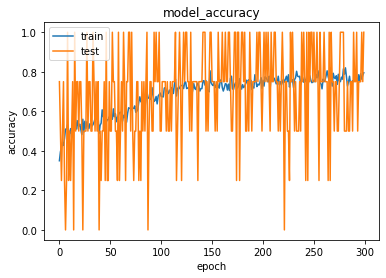

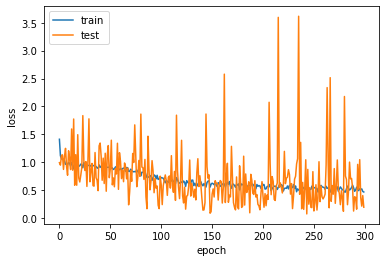

In [23]:
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('model_accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [24]:
import matplotlib.pyplot as plt

def plot_accuracy_and_loss(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(acc) + 1)

    plt.plot(epochs, acc, 'bo', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.show()

    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    plt.show()

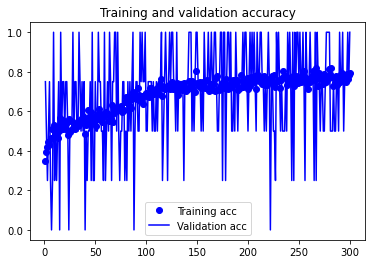

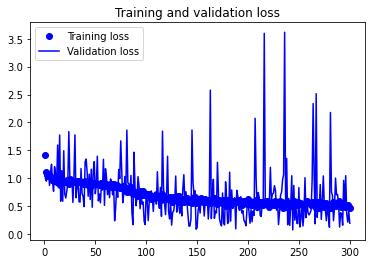

In [25]:
plot_accuracy_and_loss(hist)

In [26]:
loss, accuracy, f1_score, precision, recall = model.evaluate_generator(generator=valid_batches,verbose=1)

63/63 [==============================] - 3s 50ms/step - loss: 0.6608 - accuracy: 0.7360 - f1_m: 0.7251 - precision_m: 0.7447 - recall_m: 0.7103


In [ ]:
# cls_list = ['dogs', 'cats']
# img = Image.open('train/cat.8439.jpg')
# arr = np.asarray(img, dtype="float32")
# arr.resize((1,224,224,3))
# predict = model.predict_classes(arr)[0]
# print ('識別爲：')
# print (f'predict={predict} class={cls_list[predict]}')
# plt.imshow(img)
# plt.show

In [27]:
from numba import cuda
cuda.select_device(0)
cuda.close()